In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)

from astropy.io import fits
import os
import h5py
import re


In [2]:
'''
possible outpaths:

    daily reductions: /uufs/chpc.utah.edu/common/home/u6039752/scratch1/sandbox51/airflow-ApogeeReduction.jl/daily/outdir/
    bulk reduction: /uufs/chpc.utah.edu/common/home/sdss50/sdsswork/mwm/sandbox/airflow/outdir/
'''

'\npossible outpaths:\n\n    daily reductions: /uufs/chpc.utah.edu/common/home/u6039752/scratch1/sandbox51/airflow-ApogeeReduction.jl/daily/outdir/\n    bulk reduction: /uufs/chpc.utah.edu/common/home/sdss50/sdsswork/mwm/sandbox/airflow/outdir/\n'

In [3]:
def get_ARJL_data(tele,mjd,expid,
          outpath = '/uufs/chpc.utah.edu/common/home/u6039752/scratch1/sandbox51/airflow-ApogeeReduction.jl/daily/outdir/'):
    '''
    tele = ['apo','lco']
    mjd = e.g. 60815
    expid = use last 4 digits of night's exposure ID, e.g. 52530001 -> 1
    '''
    
    if not os.path.isdir(outpath):
        raise ValueError(f'ERROR: outpath of {outpath} does not exist.')
    
    datapath = f'{outpath}/apred/{mjd}/'
    if not os.path.isdir(datapath):
        raise ValueError(f'ERROR: specified MJD of {mjd} does not exist at outpath of {outpath}/apred/')

    search_string = ' '.join(os.listdir(datapath))
    x = re.search(f"ar1Dunical_{tele}_{mjd}_{expid:04d}.*h5", search_string)
    x_inds = x.span()
    
    fname = f'{datapath}{search_string[x_inds[0]:x_inds[1]].split(" ")[0]}'
    
    if not os.path.isfile(fname):
        raise ValueError(f'ERROR: specified exposureID of {expid} does not exist at datapath of {datapath}')
    
    f = h5py.File(fname,'r')
    
    flux_1d = np.array(f['flux_1d'])
    ivar_1d = np.array(f['ivar_1d'])
    mask_1d = np.array(f['mask_1d'])
    wavecal_type = np.array(f['wavecal_type']).astype(str)
    f.close()
    
    out_data = {
        'flux_1d':flux_1d,
        'ivar_1d':ivar_1d,
        'mask_1d':mask_1d.astype(int),
        'wavecal_type':wavecal_type,
               }
    
    return out_data

In [4]:
length = 8700
uni_wave_APOGEE = np.power(10,np.arange(4.17825, 4.17825+(length-1)*6.0e-6, step = 6.0e-6))

x_inds = np.arange(len(uni_wave_APOGEE))

bad_dark_pix_bits = 2**1 + 2**2 + 2**4
bad_flat_pix_bits = 2**6;
# most multiread CR detections are bad for other reasons
bad_cr_pix_bits = 2**7 + 2**8; # could probably drop 2^7 at least in the future (happily correct 1 read CRs)
bad_chi2_pix_bits = 2**9;

# flags for 1d flux extraction
bad_1d_failed_extract = 2**10;
bad_1d_no_good_pix = 2**11;
bad_1d_neff = 2**12;

bad_pix_bits = bad_dark_pix_bits + bad_flat_pix_bits + bad_cr_pix_bits + bad_chi2_pix_bits \
                + bad_1d_failed_extract + bad_1d_no_good_pix + bad_1d_neff

#to use masks, define good_1d = ((mask_1d & bad_pix_bits) == 0)

In [5]:
tele = 'lco'
mjd = 60823
outpath = '/uufs/chpc.utah.edu/common/home/u6039752/scratch1/sandbox51/airflow-ApogeeReduction.jl/daily/outdir/'


In [6]:
almanac_path = f'{outpath}almanac/'
almanac_f = h5py.File(f'{almanac_path}objects_{mjd}.h5','r')
exposure_keys = almanac_f[f'{tele}/{mjd}/exposures'].dtype.names

field_ids = almanac_f[f'{tele}/{mjd}/exposures/']['fieldid'].astype(str)
design_ids = almanac_f[f'{tele}/{mjd}/exposures/']['designid'].astype(str)
config_ids = almanac_f[f'{tele}/{mjd}/exposures/']['configid'].astype(str)
exposure_ids = almanac_f[f'{tele}/{mjd}/exposures/']['exposure'].astype(str)
trimmed_exposure_ids = np.copy(exposure_ids)
for j in range(len(trimmed_exposure_ids)):
    trimmed_exposure_ids[j] = trimmed_exposure_ids[j][4:]
trimmed_exposure_ints = trimmed_exposure_ids.astype(int)
exposure_types = almanac_f[f'{tele}/{mjd}/exposures/']['exptype'].astype(str)

# for key in exposure_keys:
#     print(key,almanac_f[f'{tele}/{mjd}/exposures/'][key])

almanac_f.close()

print('ExpID, FieldID, DesignID, ConfigID, ExpType')
list(zip(trimmed_exposure_ids,field_ids,design_ids,config_ids,exposure_types))


ExpID, FieldID, DesignID, ConfigID, ExpType


[('0001', '108397', '727535', '10014793', 'DARK'),
 ('0002', '108397', '727535', '10014793', 'QUARTZFLAT'),
 ('0003', '108397', '727535', '10014793', 'ARCLAMP'),
 ('0004', '108397', '727535', '10014793', 'ARCLAMP'),
 ('0005', '108397', '727535', '10014793', 'ARCLAMP'),
 ('0006', '108397', '727535', '10014793', 'ARCLAMP'),
 ('0007', '108397', '727535', '10014793', 'DARK'),
 ('0008', '108397', '727535', '10014793', 'ARCLAMP'),
 ('0009', '108397', '727535', '10014793', 'ARCLAMP'),
 ('0010', '108397', '727535', '10014793', 'DOMEFLAT'),
 ('0011', '112271', '731927', '10014794', 'OBJECT'),
 ('0012', '112271', '731927', '10014794', 'OBJECT'),
 ('0013', '112271', '731927', '10014794', 'OBJECT'),
 ('0014', '112271', '731927', '10014794', 'OBJECT'),
 ('0015', '112271', '731927', '10014794', 'OBJECT'),
 ('0016', '112271', '731927', '10014794', 'OBJECT'),
 ('0017', '106850', '724960', '10014795', 'OBJECT'),
 ('0018', '106850', '724960', '10014795', 'OBJECT'),
 ('0019', '106850', '724960', '1001479

In [19]:
#chose exposure ID from above list
expid = 11

In [20]:
#get per-fiber info

almanac_f = h5py.File(f'{almanac_path}objects_{mjd}.h5','r')

match_ind = np.where(trimmed_exposure_ints == expid)[0][0]
chosen_config_id = config_ids[match_ind]
fiber_keys = almanac_f[f'{tele}/{mjd}/fibers/fps/{chosen_config_id}'].dtype.names


fiber_types = almanac_f[f'{tele}/{mjd}/fibers/fps/{chosen_config_id}']['fiberType'].astype(str)

fiber_fib_ids = almanac_f[f'{tele}/{mjd}/fibers/fps/{chosen_config_id}']['fiberId']
good_fibs = np.where((fiber_types == 'APOGEE') & (fiber_fib_ids >= 1) & (fiber_fib_ids <= 300))[0]
good_fibs = good_fibs[np.argsort(fiber_fib_ids[good_fibs])]
fiber_fib_ids = fiber_fib_ids[good_fibs]
fiber_types = fiber_types[good_fibs]
fiber_cat_ids = almanac_f[f'{tele}/{mjd}/fibers/fps/{chosen_config_id}']['catalogid'][good_fibs]
fiber_sdss_ids = almanac_f[f'{tele}/{mjd}/fibers/fps/{chosen_config_id}']['sdss_id'][good_fibs]
fiber_catagories = almanac_f[f'{tele}/{mjd}/fibers/fps/{chosen_config_id}']['category'][good_fibs]

# for key in fiber_keys:
#     print(key,almanac_f[f'{tele}/{mjd}/fibers/fps/{chosen_config_id}'][key][good_fibs])
    
almanac_f.close()

print('FiberID, SDSS_ID, CatalogID, FiberType')
list(zip(fiber_fib_ids,fiber_sdss_ids,fiber_cat_ids,fiber_catagories))

FiberID, SDSS_ID, CatalogID, FiberType


[(1, 104111835, 63050396172712392, b'science'),
 (2, 104112712, 63050396172796595, b'science'),
 (3, 104079190, 63050396169450345, b'standard_apogee'),
 (4, 104079150, 63050396169446666, b'science'),
 (5, 104112424, 63050396172767453, b'science'),
 (6, 127254213, 27021603173763366, b'sky_apogee'),
 (7, 104112204, 63050396172744998, b'science'),
 (8, -1, -999, b'sky_apogee'),
 (9, 104111950, 63050396172723810, b'science'),
 (10, 104079090, 63050396169441615, b'science'),
 (11, 104113538, 63050396172872630, b'science'),
 (12, 104113468, 63050396172866615, b'science'),
 (13, 104111962, 63050396172724623, b'science'),
 (14, 104112862, 63050396172809096, b'science'),
 (15, 104113456, 63050396172865853, b'science'),
 (16, -1, -999, b'sky_apogee'),
 (17, -1, -999, b''),
 (18, 104111994, 63050396172726832, b'science'),
 (19, 104111875, 63050396172715733, b'science'),
 (20, 104112711, 63050396172796493, b'science'),
 (21, 104113053, 63050396172826552, b'science'),
 (22, 104112996, 6305039617282

In [21]:
exp_data = get_ARJL_data(tele,mjd,expid,outpath=outpath)

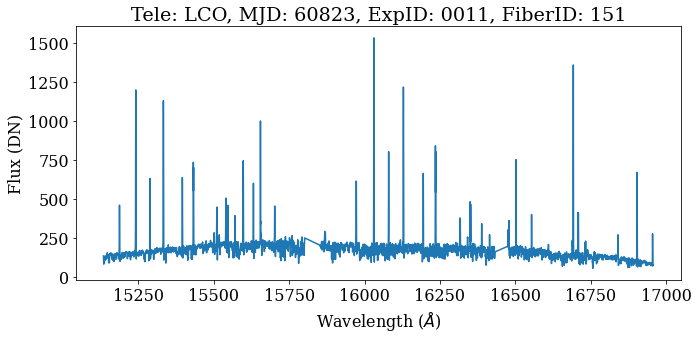

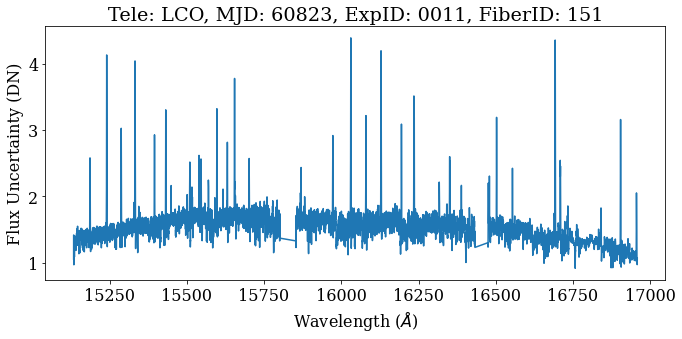

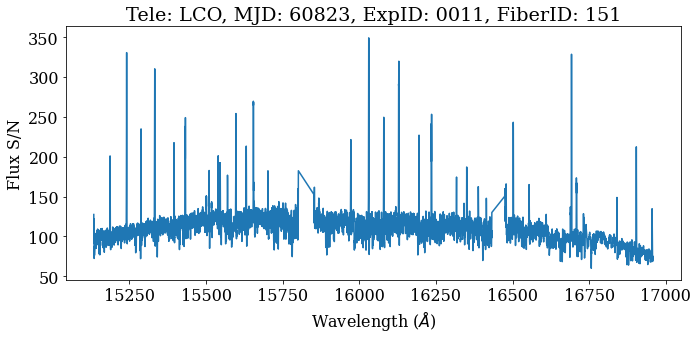

In [26]:
'''
NOTE:

fiberid is the survey definition, and it goes from 1:300
To convert to the python index in the output files, use fiber_ind = (300-fiberid)

'''

fiberid = 151
fiber_ind = 300-fiberid

title = f'Tele: {tele.upper()}, MJD: {mjd}, ExpID: {expid:04d}, FiberID: {fiberid}'

curr_flux = exp_data['flux_1d'][fiber_ind]
curr_ivar = exp_data['ivar_1d'][fiber_ind]
curr_good = ((exp_data['mask_1d'][fiber_ind] & bad_pix_bits) == 0) & (curr_flux > 0) & (curr_ivar > 0)
curr_err = np.power(curr_ivar,-0.5)

plt.figure(figsize=(10,5))
plt.title(title)
plt.plot(uni_wave_APOGEE[curr_good],curr_flux[curr_good])
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux (DN)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.title(title)
plt.plot(uni_wave_APOGEE[curr_good],curr_err[curr_good])
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux Uncertainty (DN)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.title(title)
plt.plot(uni_wave_APOGEE[curr_good],curr_flux[curr_good]/curr_err[curr_good])
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux S/N')
plt.tight_layout()
plt.show()
